# Projet de machine learning utilisant le dataset de kaggle global ads performance
# Ce jeu de données contient des données de performance publicitaire au niveau des campagnes sur trois grandes plateformes de publicité digitale : Google Ads, Meta Ads (Facebook/Instagram) et TikTok Ads.
# # On va se base ici sur les modèles de regression pour prédire le revenu ou le ROAS

In [229]:
import pandas as pd
import numpy as np
import matplotlib as mp

from sklearn.model_selection import train_test_split
from sklearn.impute  import SimpleImputer
from sklearn.preprocessing  import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor



pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [230]:
gloabl_ads_file_path = "input/global_ads_performance_dataset.csv"
global_ads_data = pd.read_csv(gloabl_ads_file_path, sep=",")

#global_ads_data.head()

#print(global_ads_data.shape) (1800,14)
#global_ads_data.describe()
global_ads_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1800 non-null   str    
 1   platform       1800 non-null   str    
 2   campaign_type  1800 non-null   str    
 3   industry       1800 non-null   str    
 4   country        1800 non-null   str    
 5   impressions    1800 non-null   int64  
 6   clicks         1800 non-null   int64  
 7   CTR            1800 non-null   float64
 8   CPC            1800 non-null   float64
 9   ad_spend       1800 non-null   float64
 10  conversions    1800 non-null   int64  
 11  CPA            1800 non-null   float64
 12  revenue        1800 non-null   float64
 13  ROAS           1800 non-null   float64
dtypes: float64(6), int64(3), str(5)
memory usage: 197.0 KB


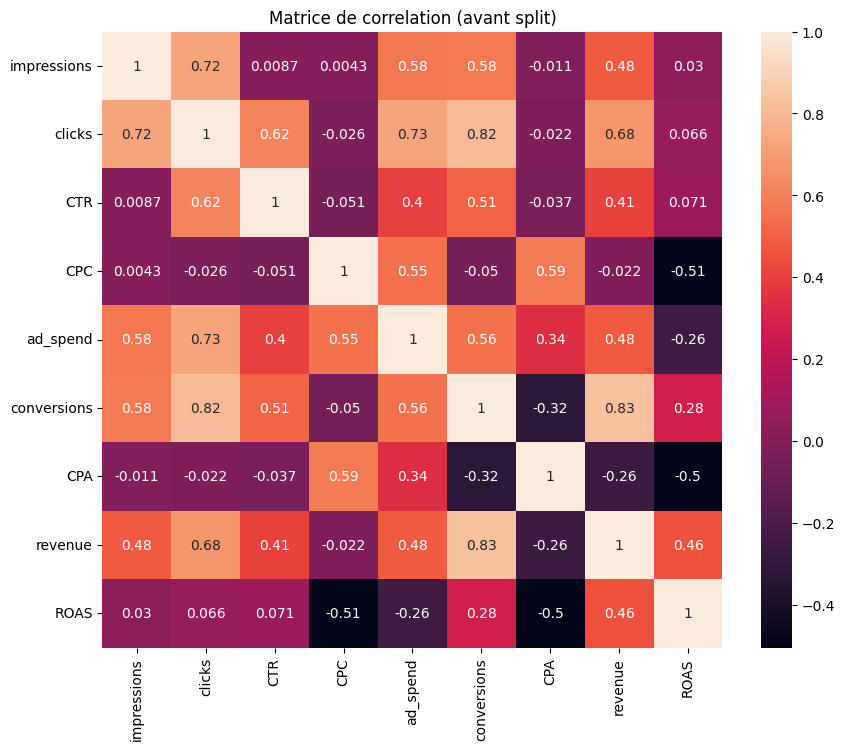

In [231]:
#Matrice de correlation
num_total_cols = [col for col in global_ads_data.columns if global_ads_data[col].dtype in ['int64', 'float64']]
cor_global_ads = global_ads_data[num_total_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor_global_ads, annot=True)
plt.title('Matrice de correlation (avant split)')
plt.show()

In [232]:
global_ads_data.keys()
num_cols = [col for col in global_ads_data.columns if global_ads_data[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in global_ads_data.columns if global_ads_data[col].dtype in ['str']]

print(num_cols)
print(cat_cols)

['impressions', 'clicks', 'CTR', 'CPC', 'ad_spend', 'conversions', 'CPA', 'revenue', 'ROAS']
['date', 'platform', 'campaign_type', 'industry', 'country']


In [233]:
global_ads_data['revenue'].describe()

count      1800.000000
mean      30101.850450
std       34560.032941
min         142.690000
25%        7275.757500
50%       18362.965000
75%       38963.385000
max      295028.260000
Name: revenue, dtype: float64

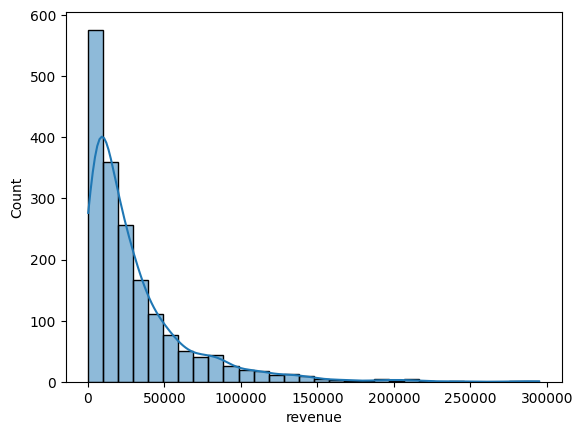

In [234]:


sns.histplot(global_ads_data["revenue"], bins=30, kde=True)
plt.show()

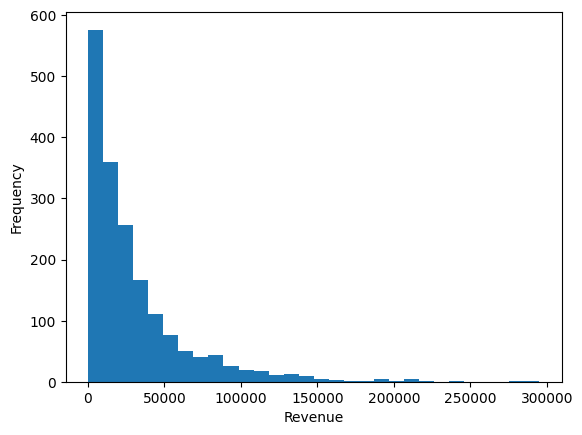

In [235]:
plt.hist(global_ads_data["revenue"], bins=30)
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

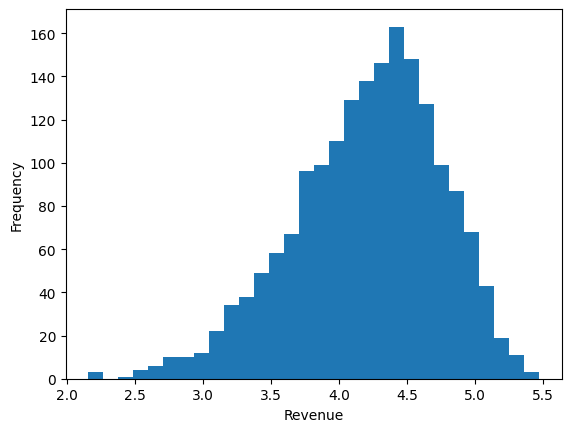

In [236]:
global_ads_data["log_revenue"] = np.log10(global_ads_data["revenue"])
plt.hist(global_ads_data["log_revenue"], bins=30)
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

In [237]:
global_ads_data["log_revenue"].describe()

count    1800.000000
mean        4.205620
std         0.540937
min         2.154394
25%         3.861878
50%         4.263941
75%         4.590657
max         5.469864
Name: log_revenue, dtype: float64

## Features numeriques à garder
- Impressions
- clicks
- ad_spend
- conversions

## Target
- Revenu

In [238]:
# feature categorielle

features_cat_cols = [col for col in global_ads_data.columns if global_ads_data[col].dtype in ['str']]





In [239]:
global_ads_data["days_since_start"] = (pd.to_datetime(global_ads_data["date"]) - pd.to_datetime(global_ads_data["date"]).min()).dt.days
X = global_ads_data.drop(['date','ROAS','revenue','CPC','CPA','CTR','log_revenue'], axis=1)
X.head()

,platform,campaign_type,industry,country,impressions,clicks,ad_spend,conversions,days_since_start
0,Google Ads,Search,Fintech,UAE,59886,2113,2662.38,159,20
1,TikTok Ads,Search,EdTech,UK,135608,5220,6159.60,411,21
2,TikTok Ads,Video,Healthcare,USA,92313,5991,5092.35,267,166
3,TikTok Ads,Shopping,SaaS,Germany,83953,5935,7834.20,296,1
4,TikTok Ads,Search,Healthcare,UK,91807,4489,8663.77,107,52


In [240]:
y = global_ads_data['log_revenue']
y.head()

0    3.681551
1    4.807039
2    4.020737
3    4.703335
4    3.527569
Name: log_revenue, dtype: float64

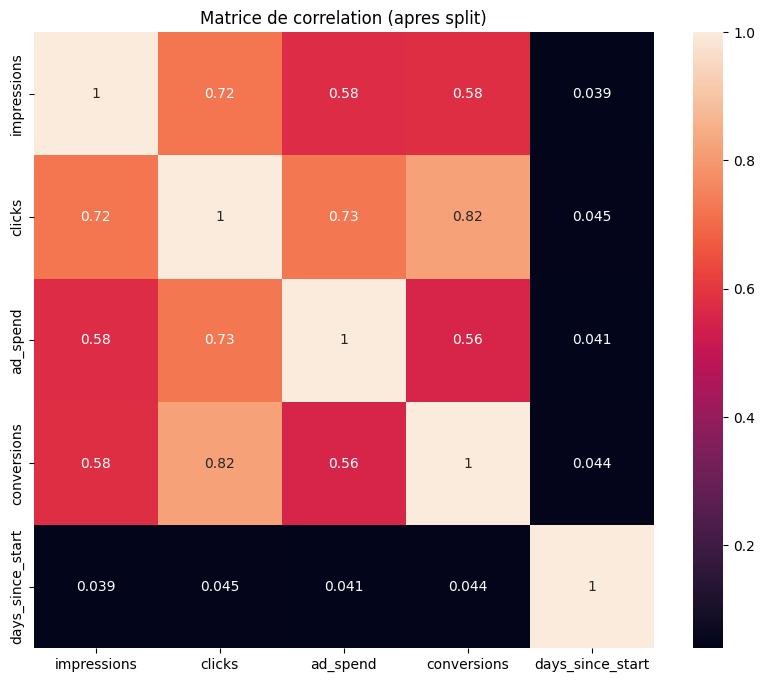

In [241]:
num_X_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
cor_global_ads = X[num_X_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor_global_ads, annot=True)
plt.title('Matrice de correlation (apres split)')
plt.show()

In [242]:
cat_X_cols = [col for col in X.columns if X[col].dtype in ['str']]

cardinality_dict = X[cat_X_cols].nunique().to_dict()

print(cardinality_dict)

{'platform': 3, 'campaign_type': 4, 'industry': 5, 'country': 7}


## Split & test

In [243]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_valid.shape)

print(y_train.value_counts())
print(y_valid.value_counts())

(1440, 9)
(360, 9)
log_revenue
4.565569    2
3.026950    2
4.488511    1
2.154454    1
3.418821    1
           ..
5.165701    1
4.496358    1
4.588948    1
3.615274    1
4.464208    1
Name: count, Length: 1438, dtype: int64
log_revenue
4.242916    1
4.046758    1
4.930786    1
4.597495    1
4.672685    1
           ..
4.765548    1
3.203098    1
4.158686    1
3.321805    1
4.370698    1
Name: count, Length: 360, dtype: int64


## Modele Baseline

In [244]:
# Importer 


processor = ColumnTransformer(
    transformers=[
        ('num', "passthrough" , num_X_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore") , cat_X_cols)])



## Modele baseline

In [245]:
baseline = Pipeline(steps=[('preparation', processor),
                      ('model', LinearRegression())])

baseline.fit(X_train, y_train)

y_pred_baselin = baseline.predict(X_valid)

In [246]:
## Evaluation Baseline

In [247]:
mse = mean_squared_error(y_valid, y_pred_baselin)
print(mse)

r2 = r2_score(y_valid, y_pred_baselin)
print(r2)

0.11811172952708893
0.6300482977487153


## Modele avec regression linéaire avec penalités



In [248]:
processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler() , num_X_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore") , cat_X_cols)])
reg_pen = Pipeline(steps=[('preparation', processor),
                      ('model', Ridge(alpha=10))])

reg_pen.fit(X_train, y_train)

y_pred_reg_pen = reg_pen.predict(X_valid)


## Evaluation

In [249]:
mse_reg = mean_squared_error(y_valid, y_pred_reg_pen)
print(mse_reg)

r2_reg = r2_score(y_valid, y_pred_reg_pen)
print(r2_reg)

0.11779581730477026
0.6310378037433928


## Modele RandomForest

In [250]:
processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler() , num_X_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore") , cat_X_cols)])
forest = Pipeline(steps=[('preparation', processor),
                      ('model', RandomForestRegressor(n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1))])

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_valid)

mse_forest= mean_squared_error(y_valid, y_pred_forest)
print(mse_forest)

r2_forest = r2_score(y_valid, y_pred_forest)
print(r2_forest)


0.07317703715323329
0.7707935564999477


# Modele Gradient

In [251]:
processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler() , num_X_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore") , cat_X_cols)])
forest = Pipeline(steps=[('preparation', processor),
                      ('model', HistGradientBoostingRegressor(random_state=42))])

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_valid)

mse_forest= mean_squared_error(y_valid, y_pred_forest)
print(mse_forest)

r2_forest = r2_score(y_valid, y_pred_forest)
print(r2_forest)

0.0782838337089511
0.7547979556700953
